# Deep Hedging FNN and Utility Indifference pricing

Import first all relevant libraries (and set plotting style):

In [ ]:
import numpy as np
import math
import numpy.random as npr
from scipy.stats import norm
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as kb
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Pre-requisite: Formulas 

Functions that compute <i>option</i> prices and delta under the Black-Scholes model:

In [ ]:
def BlackScholesCall(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    d2 = d1 - sigma * np.sqrt(T)
    return norm.cdf(d1) * S0 - norm.cdf(d2) * K * np.exp(-r*T)
def BlackScholesCallDelta(S0,r,sigma,T,K):
    d1 =  1 / (sigma * np.sqrt(T)) * (np.log(S0/K) + (r+sigma**2/2)*T)
    return norm.cdf(d1)

def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                          steps, Npaths, return_vol=False):
    np.random.seed(12345)
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]), 
                                           cov = np.array([[1,rho],
                                                          [rho,1]]), 
                                           size=Npaths) * np.sqrt(dt) 
        
        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) ) 
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t
        prices_transpose = np.transpose(prices)
        sigs_transpose = np.transpose(sigs)
        
    if return_vol:
        return prices, sigs

    return prices

def call_price(stock_path, steps, N):
  #prices = np.transpose(generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi, 
                        #steps, N, return_vol=False))
  
  call_array = stock_path[-1] - K
  call_price = np.mean(call_array)
  return call_price

def loss_util(lamb,k,option_type):
    def loss(y_true,y_pred):
        gain = kb.sum(y_pred * y_true,axis=-1)
        ST = S_0 + kb.sum(y_true, axis=-1)
        var = kb.abs(y_pred[:,1:T]-y_pred[:,0:T-1])   
        tc = (kb.cumsum(y_true, axis=1)+S_0)*k
        tc_0 = k * S_0
        cost = kb.abs(y_pred[:,0])*tc_0+kb.abs(y_pred[:,T-1])*tc[:,T-1] + kb.sum(tc[:,0:T-1]*var, axis=1)
        
        c = S_0*C
        indicator_AC = tf.math.maximum(tf.math.sign(y_pred[:,int(T/2):int(T/2) +1] - B_AC),0.) # 1 if Autocalls at 6M, 0 otherwise
        pmax = tf.math.reduce_max(kb.cumsum(y_true, axis=1)+S_0,axis=-1) #running maximum
        pmin = tf.math.reduce_min(kb.cumsum(y_true, axis=1)+S_0,axis=-1) #running minimum
        indicator_AC_cont = tf.math.maximum(tf.math.sign(pmax - B_AC),0.) #1 if running max>B_AC, 0 otherwise
        indicator_DIP = tf.math.maximum(tf.math.sign(B_DIP-pmin),0.) # 1 if running_minimum<B_DIP, 0 otherwise
        
        option_list = {
        'call' : kb.maximum(S_0 + kb.sum(y_true,axis=-1) - K,0.),
        'put' : kb.maximum(-S_0 - kb.sum(y_true,axis=-1) + K,0.),
        'cuo' : kb.maximum(S_0 + kb.sum(y_true,axis=-1) - K,0.)*tf.math.maximum(tf.math.sign(B_AC-pmax),0.),
        'autocall' : (S_0 + c)*(indicator_AC) \
                   +(S_0 + c)*(1-indicator_AC) -kb.maximum(K - S_0 - kb.sum(y_true,axis=-1),0.)\
                   *(indicator_DIP)*(1-indicator_AC), #Pays back performance at maturity if doesn't autocalls at 6M
        'autocall_continuous' : (S_0 + c)*(indicator_AC_cont) \
                   +(S_0 + c)*(1-indicator_AC_cont) -kb.maximum(K - S_0 - kb.sum(y_true,axis=-1),0.)\
                   *(indicator_DIP)*(1-indicator_AC_cont), #Autocall obs date is continuous
        }
        
        liability = option_list[option_type]
        pnl = gain - liability - cost
        return tf.math.expm1(-lamb*pnl)/lamb
    return loss

# Deep Hedging: Parameters

In [ ]:
epochs, batch_size = 30, 100
option_type = "autocall_continuous"
output_activation_layer = "softplus" # "sigmoid", "tanh", "softplus"
B_DIP, B_AC,C = 0.7, 1.3, 0.03

# Black Scholes

## Simulating Stock Path

We set the parameter values as before:

In [ ]:
sigma = 0.5
mu = -0.5*sigma**2 # Such that mu is a martingale, we'll let r=0 but can be relaxed
T = 100
S_0 = 1
r=0

And we generate the training samples:

In [ ]:
npr.seed(12345)
N = 100000
xi = npr.normal(0, np.sqrt(1 / T), (N, T))
W = np.apply_along_axis(np.cumsum, 1, xi)
W = np.concatenate((np.zeros((N, 1)), W),1)
drift = np.linspace(0, mu , T + 1)
drift = np.reshape(drift, (1, T + 1))
drift = np.repeat(drift, N, axis=0)
Ti = np.tile(np.linspace(0, 1, T+1)[0:T], (N, 1))
S_BS = S_0 * np.exp(drift + sigma * W)
dS_BS = np.diff(S_BS, 1, 1)
X_BS = np.stack([Ti, S_BS[:,0:T]], axis=-1)
#tim = np.linspace(0,1,T+1)

## Training Network

Utility Indifference pricing with Exponential Utility:

\begin{align} \label{eq:exp_utility_function}
-U_\lambda(x):=\frac{1}{\lambda}\exp{(-\lambda x)},\qquad x \in \mathbb{R}
\end{align} 

We used a network $f$ such that
\begin{equation*}
f \in \mathcal{N}_4(2,100,100,100,1; \mathrm{ReLU},\mathrm{ReLU},\mathrm{ReLU},\mathrm{Softplus}).
\end{equation*}

In [ ]:
K=1
risk_aversion = (1,5,10,15)
cost_level = (0,0.0005,0.005,0.05)

F1_BS, F5_BS, F10_BS, F15_BS = [], [], [], []
F_BS = [F1_BS, F5_BS, F10_BS, F15_BS]
for i in range(len(risk_aversion)):
  for j in range(len(risk_aversion)):
    F_BS[i].append(keras.Sequential([
    keras.layers.InputLayer(input_shape=(T, 2)),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation=output_activation_layer)]))

In [ ]:
i, j = 0, 0
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 0, 1
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 0, 2
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 0, 3
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 1, 0
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 1, 1
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 1, 2
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 1, 3
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 2, 0
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 2, 1
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 2, 2
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 2, 3
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 3, 0
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 3, 1
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 3, 2
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

i, j = 3, 3
F_BS[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BS[i][j].fit(X_BS, dS_BS, batch_size=batch_size, epochs=epochs)

Epoch 1/30
1000/1000 [==============================] - 9s 3ms/step - loss: 1.3973
Epoch 2/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3933
Epoch 3/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3931
Epoch 4/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3929
Epoch 5/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3927
Epoch 6/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3927
Epoch 7/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3926
Epoch 8/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3925
Epoch 9/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3927
Epoch 10/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3925
Epoch 11/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3926
Epoch 12/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3924
E

## Indifference Pricing

In [ ]:
for i in range(len(F_BS)):
  for j in range(len(F_BS[i])):
    loss = F_BS[i][j].evaluate(X_BS,dS_BS)
    result = (1/risk_aversion[i] * np.log(risk_aversion[i]*np.float_(loss)+1))
    k_cost = cost_level[j]*100
    print(r'Risk Aversion=%1.f' % risk_aversion[i], r'Cost level=%1.2f' % k_cost + "%", r'Indiff pricing=%1.22f' % result)

3125/3125 [==============================] - 6s 2ms/step - loss: 1.3914
Risk Aversion=1 Cost level=0.00% Indiff pricing=0.8718985006504971213559
3125/3125 [==============================] - 6s 2ms/step - loss: 1.3960
Risk Aversion=1 Cost level=0.05% Indiff pricing=0.8737857656468596134758
3125/3125 [==============================] - 6s 2ms/step - loss: 1.4186
Risk Aversion=1 Cost level=0.50% Indiff pricing=0.8831788888117071412154
3125/3125 [==============================] - 6s 2ms/step - loss: 1.4382
Risk Aversion=1 Cost level=5.00% Indiff pricing=0.8912506246322071667976
3125/3125 [==============================] - 6s 2ms/step - loss: 16.8258
Risk Aversion=5 Cost level=0.00% Indiff pricing=0.8888333482875824254066
3125/3125 [==============================] - 6s 2ms/step - loss: 17.0055
Risk Aversion=5 Cost level=0.05% Indiff pricing=0.8909335891104017690623
3125/3125 [==============================] - 6s 2ms/step - loss: 18.3841
Risk Aversion=5 Cost level=0.50% Indiff pricing=0.90634

## Delta Hedge Ratio for varying S

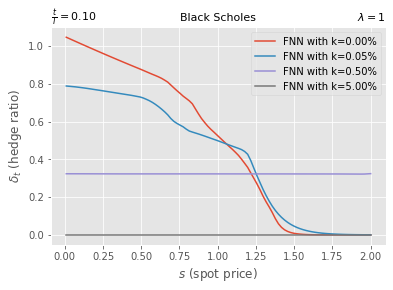

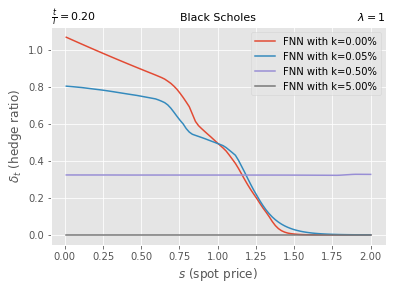

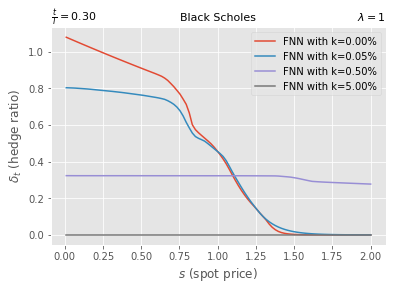

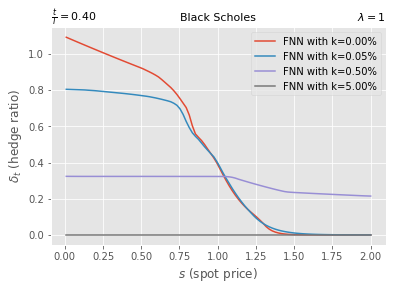

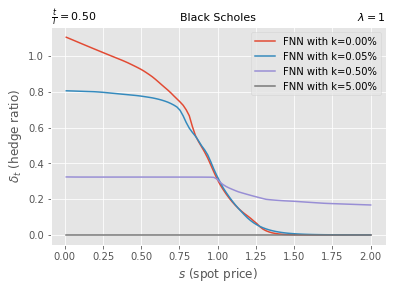

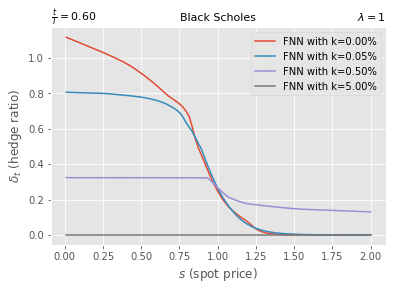

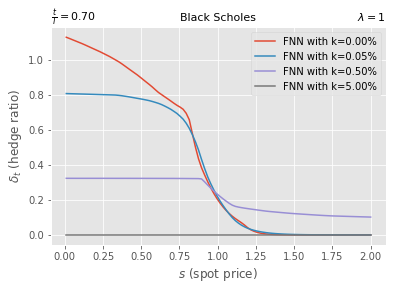

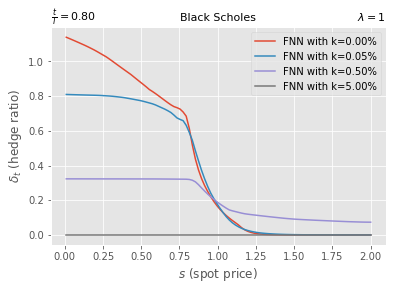

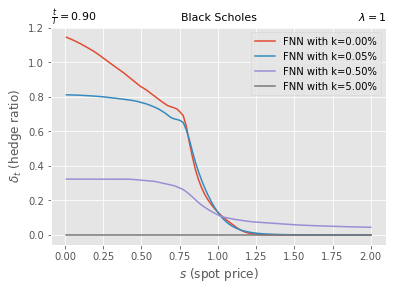

In [ ]:
Lambda=1 
I_in_list=0

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BS[I_in_list])):
      Delta_learn = np.reshape(F_BS[I_in_list][j].predict(Xpr), (100,))
      k = cost_level[j]*100
      plt.plot(Spr, Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Black Scholes', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

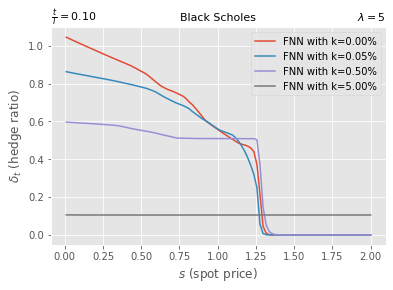

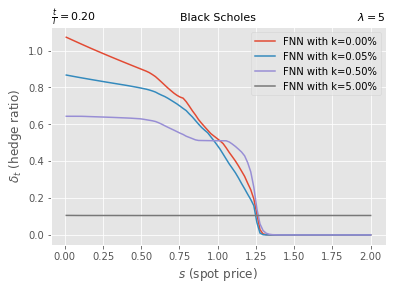

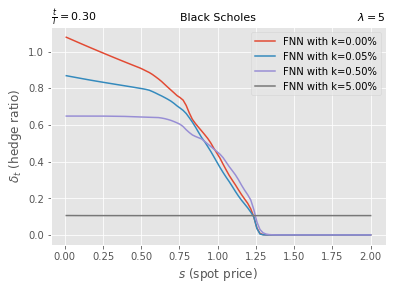

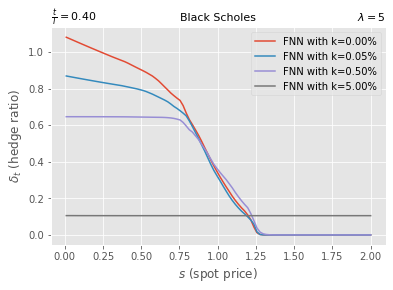

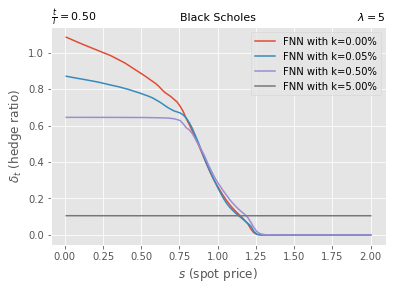

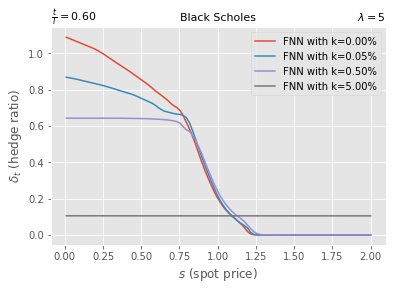

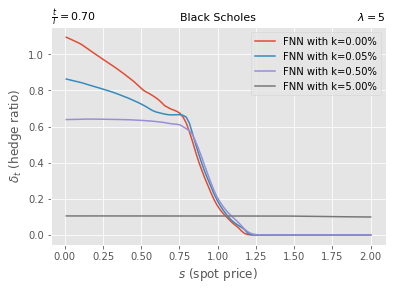

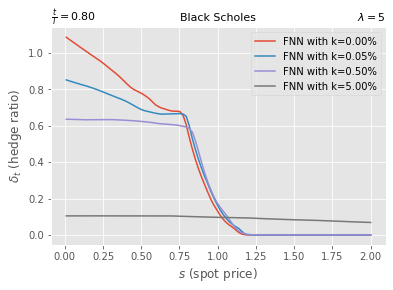

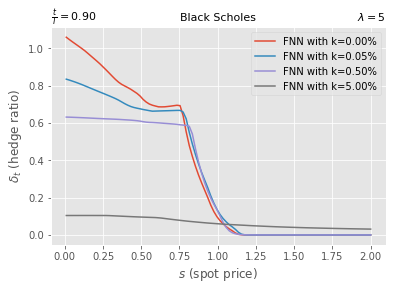

In [ ]:
Lambda=5
I_in_list=1

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BS[I_in_list])):
      Delta_learn = np.reshape(F_BS[I_in_list][j].predict(Xpr), (100,))
      k = cost_level[j]*100
      plt.plot(Spr, Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Black Scholes', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

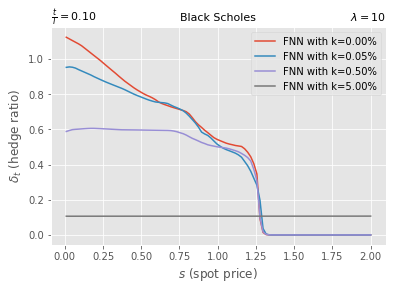

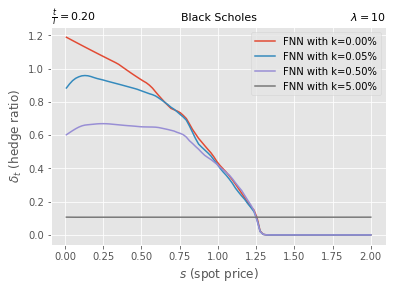

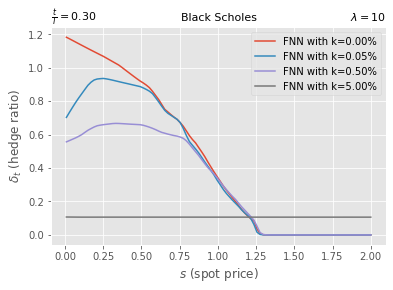

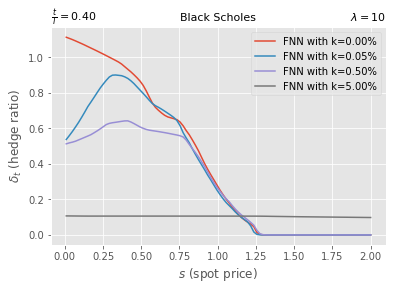

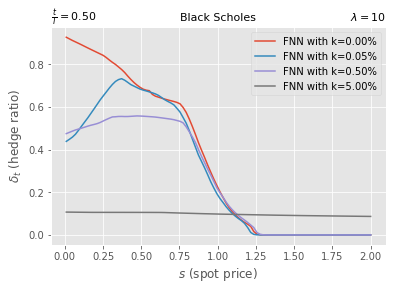

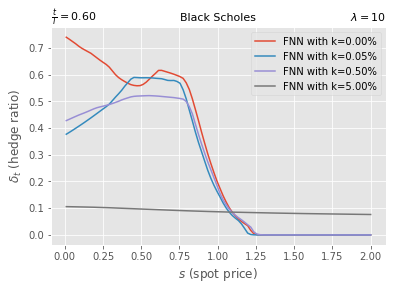

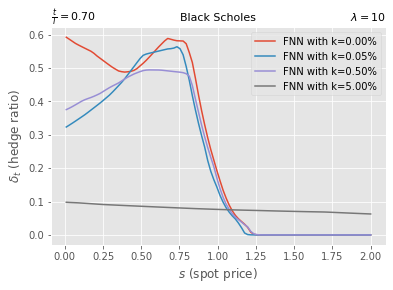

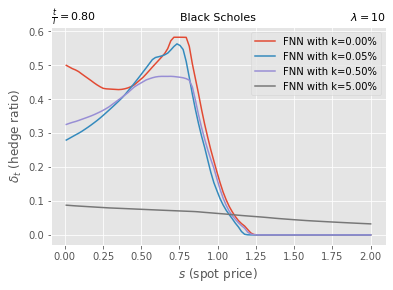

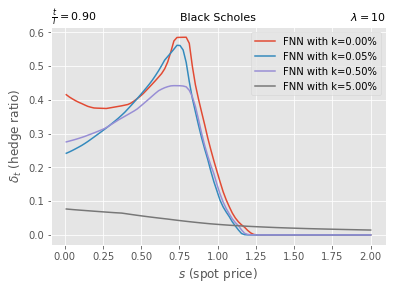

In [ ]:
Lambda=10
I_in_list=2
for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BS[I_in_list])):
      Delta_learn = np.reshape(F_BS[I_in_list][j].predict(Xpr), (100,))
      k = cost_level[j]*100
      plt.plot(Spr, Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Black Scholes', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

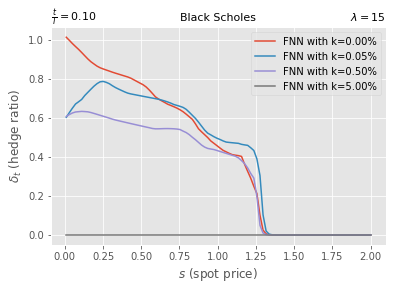

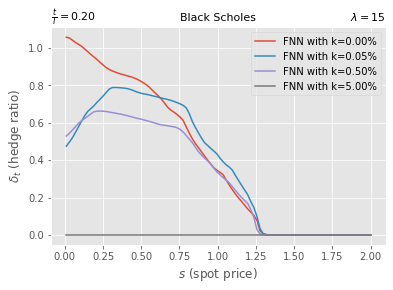

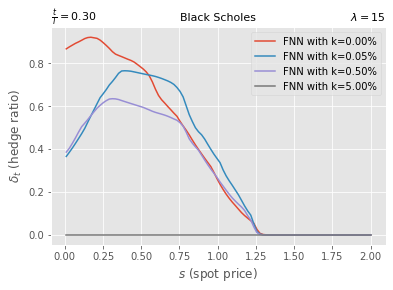

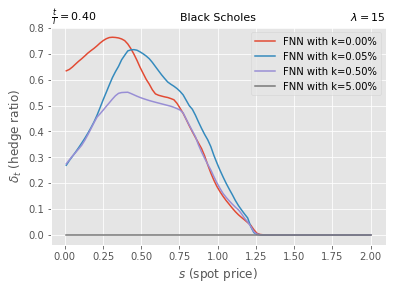

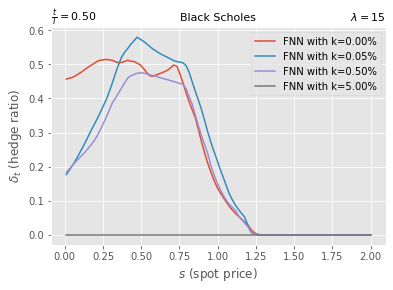

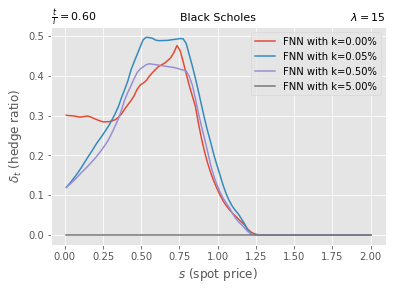

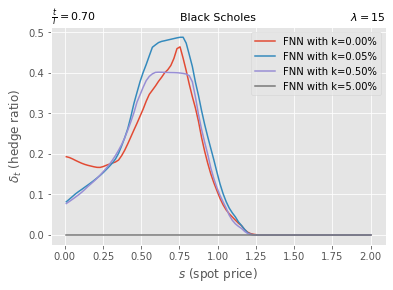

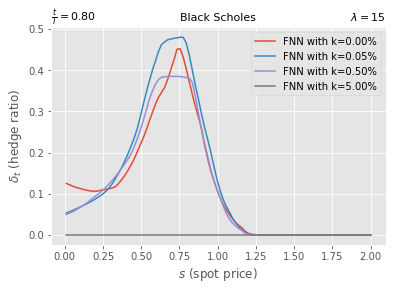

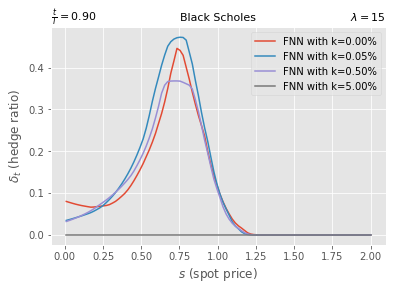

In [ ]:
Lambda=15
I_in_list=3
for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BS[I_in_list])):
      Delta_learn = np.reshape(F_BS[I_in_list][j].predict(Xpr), (100,))
      k = cost_level[j]*100
      plt.plot(Spr, Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Black Scholes', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

## Stock Path simulation

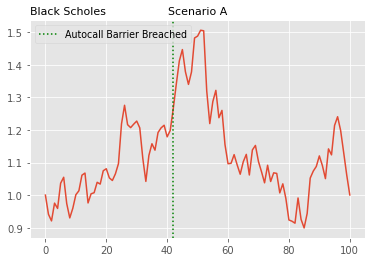

Text(0.5, 1.0, 'Scenario B')

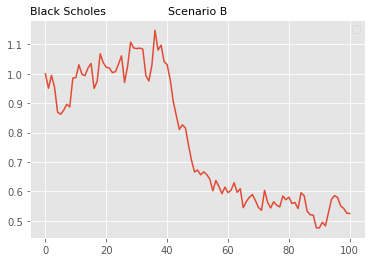

In [ ]:
range_stock_BS = [8, 10]

i  = range_stock_BS[0]
plt.plot(S_BS[i])
#plt.axhline(y = B_AC, color = 'green', linestyle='dotted')
plt.axvline(x = 42, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.legend(loc=2,fontsize=9.5)
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.show()

i  = range_stock_BS[1]
plt.plot(S_BS[i])
plt.legend()
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)

## Delta Hedge Ratio for varying t

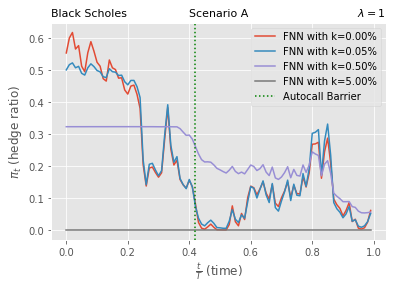

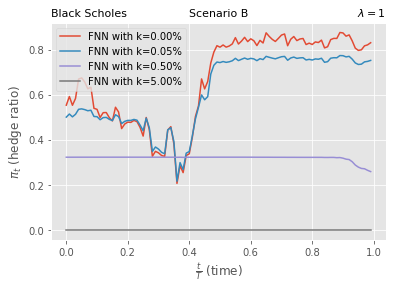

In [ ]:
Lambda=1
I_in_list=0

i  = range_stock_BS[0]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.42, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_BS[1]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

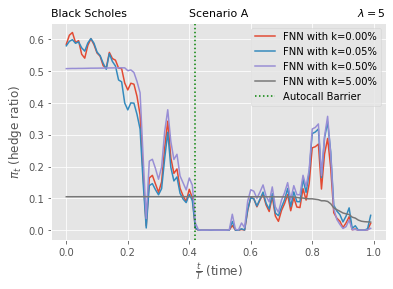

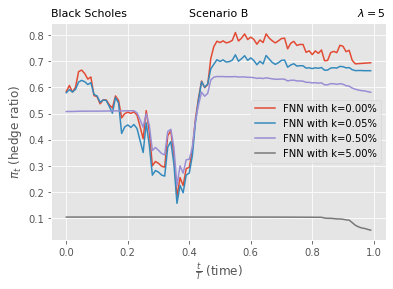

In [ ]:
Lambda=5
I_in_list=1

i  = range_stock_BS[0]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.42, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_BS[1]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

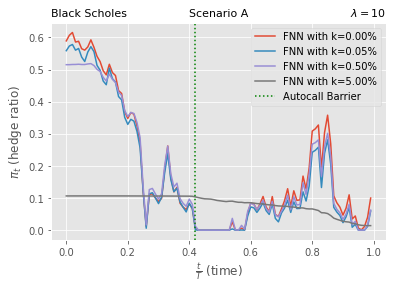

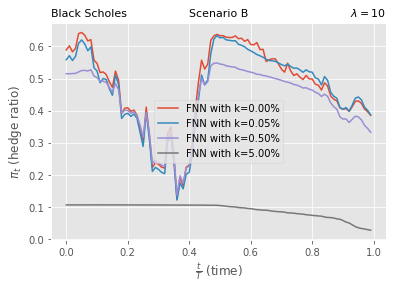

In [ ]:
Lambda=10
I_in_list=2

i  = range_stock_BS[0]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.42, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_BS[1]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

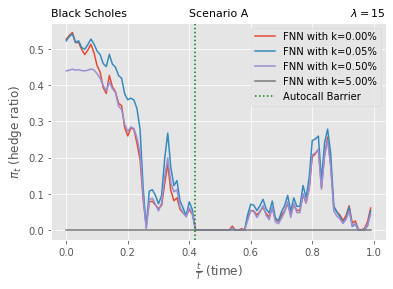

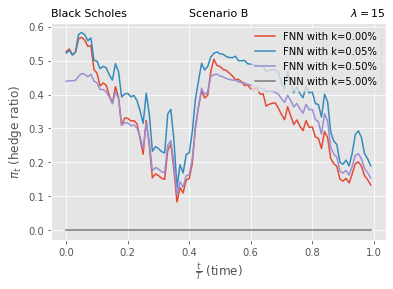

In [ ]:
Lambda=15
I_in_list=3

i  = range_stock_BS[0]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.42, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_BS[1]
for j in range(len(F_BS)):
    Delta_learn = np.reshape(F_BS[I_in_list][j].predict(X_BS[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BS[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\pi_t$ (hedge ratio)")
plt.title(r'Black Scholes', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

# Heston

## Simulating Stock Path

We set the parameter values as before:

In [ ]:
###Heston
kappa =3
theta = 0.04
v_0 =  sigma**2 # v_t is variance, hence sigma 0 squared
xi = 0.6
r = 0
S_0 = 1
N = 100000
steps = 101
T = 100
rho = -0.8
prices= generate_heston_paths(S_0, 1, r, kappa, theta,v_0, rho, xi, steps, N)

And we generate the training samples:

In [ ]:
Ti = np.tile(np.linspace(0, 1, T+1)[0:T], (N, 1))
S_HEST = prices
dS_HEST = np.diff(S_HEST, 1, 1)
X_HEST = np.stack([Ti, S_HEST[:,0:T]], axis=-1)

## Training Network

Utility Indifference pricing with Exponential Utility:

\begin{align} \label{eq:exp_utility_function}
-U_\lambda(x):=\frac{1}{\lambda}\exp{(-\lambda x)},\qquad x \in \mathbb{R}
\end{align} 

We used a network $f$ such that
\begin{equation*}
f \in \mathcal{N}_4(2,100,100,100,1; \mathrm{ReLU},\mathrm{ReLU},\mathrm{ReLU},\mathrm{sigmoid}).
\end{equation*}

In [ ]:
K=1
risk_aversion = (1,5,10,15)
cost_level = (0,0.0005,0.005,0.05)
    
F1_HEST, F5_HEST, F10_HEST, F15_HEST = [], [], [], []
F_HEST = [F1_HEST,F5_HEST,F10_HEST,F15_HEST] #for each lambda
for i in range(len(risk_aversion)):
  for j in range(len(risk_aversion)):
    F_HEST[i].append(keras.Sequential([
    keras.layers.InputLayer(input_shape=(T, 2)),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation=output_activation_layer)]))


In [ ]:
i, j = 0, 0
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 0, 1
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 0, 2
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 0, 3
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 1, 0
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 1, 1
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 1, 2
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 1, 3
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 2, 0
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 2, 1
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 2, 2
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 2, 3
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 3, 0
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 3, 1
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 3, 2
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

i, j = 3, 3
F_HEST[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_HEST[i][j].fit(X_HEST, dS_HEST, batch_size=batch_size, epochs=epochs)

Epoch 1/30
1000/1000 [==============================] - 7s 3ms/step - loss: 1.5495
Epoch 2/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5462
Epoch 3/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5461
Epoch 4/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5461
Epoch 5/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5459
Epoch 6/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5458
Epoch 7/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5459
Epoch 8/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5458
Epoch 9/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5457
Epoch 10/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5456
Epoch 11/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5459
Epoch 12/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5456
E

## Indifference pricing

In [ ]:
for i in range(len(F_HEST)):
  for j in range(len(F_HEST[i])):
    loss = F_HEST[i][j].evaluate(X_HEST,dS_HEST)
    result = (1/risk_aversion[i] * np.log(risk_aversion[i]*np.float_(loss)+1))
    k_cost = cost_level[j]*100
    print(r'Risk Aversion=%1.f' % risk_aversion[i], r'Cost level=%1.2f' % k_cost + "%", r'Indiff pricing=%1.22f' % result)

3125/3125 [==============================] - 7s 2ms/step - loss: 1.5456
Risk Aversion=1 Cost level=0.00% Indiff pricing=0.9343678525695914283133
3125/3125 [==============================] - 7s 2ms/step - loss: 1.5497
Risk Aversion=1 Cost level=0.05% Indiff pricing=0.9359601444350396093341
3125/3125 [==============================] - 8s 2ms/step - loss: 1.5656
Risk Aversion=1 Cost level=0.50% Indiff pricing=0.9422010728637325582824
3125/3125 [==============================] - 7s 2ms/step - loss: 1.5780
Risk Aversion=1 Cost level=5.00% Indiff pricing=0.9470064400824819150770
3125/3125 [==============================] - 7s 2ms/step - loss: 21.9766
Risk Aversion=5 Cost level=0.00% Indiff pricing=0.9416949176877317251311
3125/3125 [==============================] - 7s 2ms/step - loss: 22.2309
Risk Aversion=5 Cost level=0.05% Indiff pricing=0.9439754753117715058153
3125/3125 [==============================] - 7s 2ms/step - loss: 23.6128
Risk Aversion=5 Cost level=0.50% Indiff pricing=0.95593

## Delta Hedge Ratio for varying S

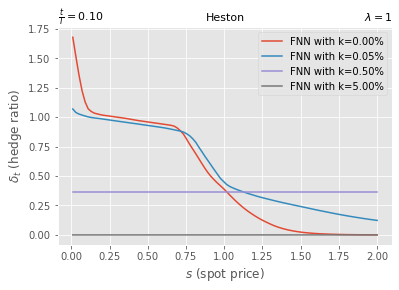

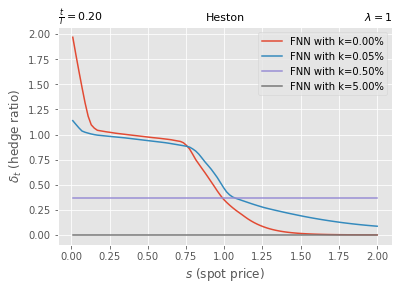

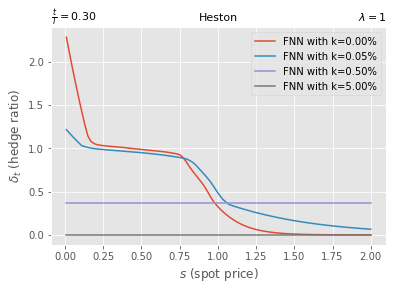

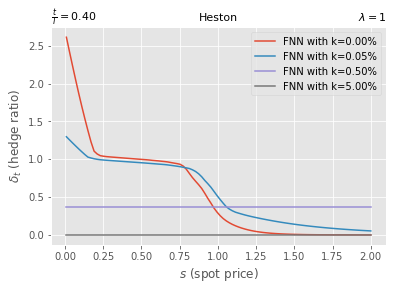

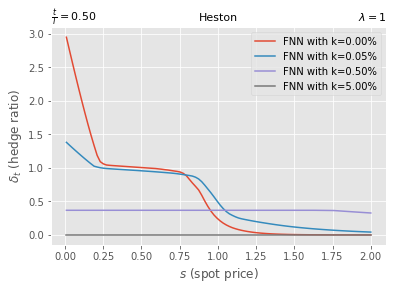

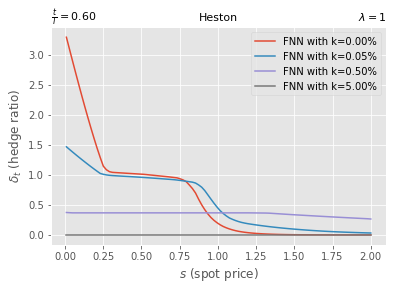

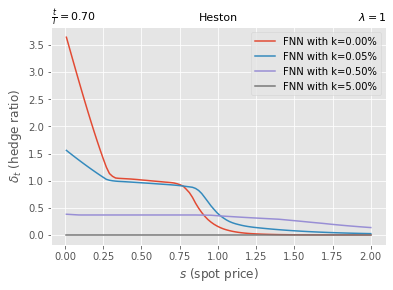

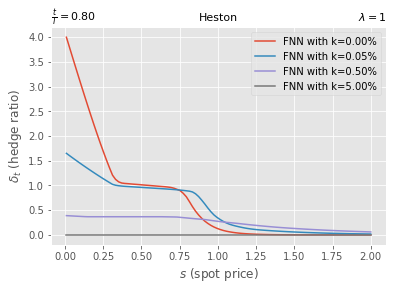

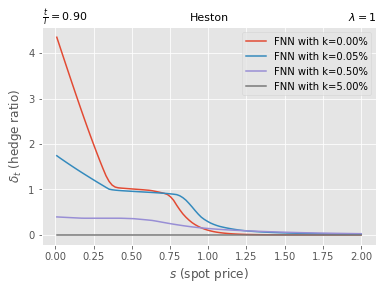

In [ ]:
Lambda=1
I_in_list=0

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_HEST[I_in_list])):
        Delta = np.reshape(F_HEST[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Heston', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

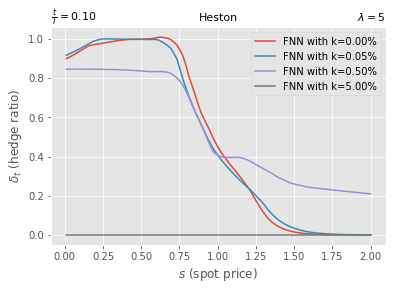

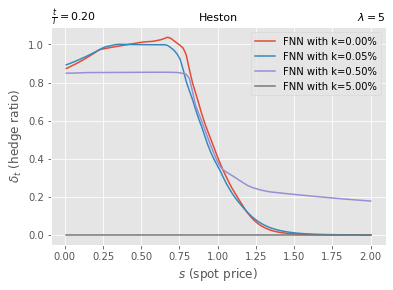

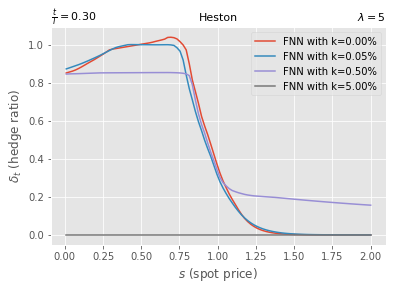

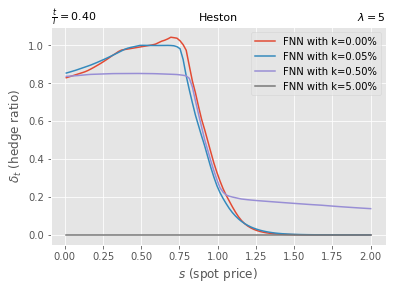

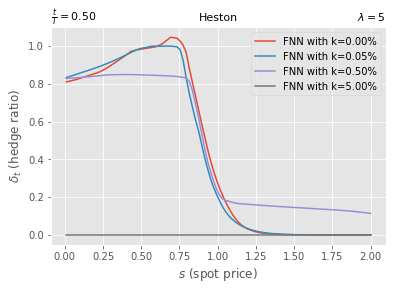

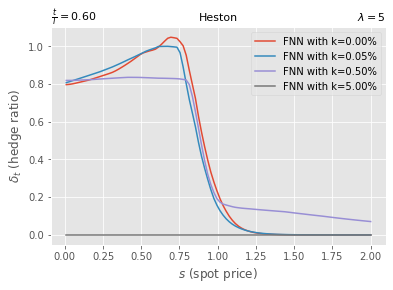

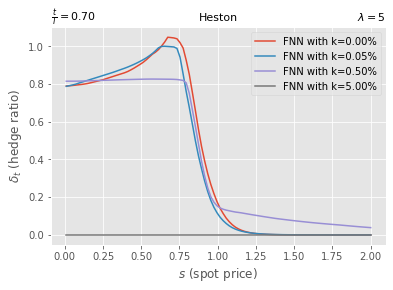

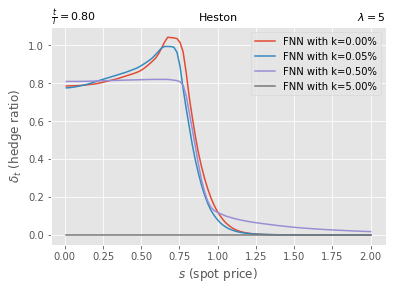

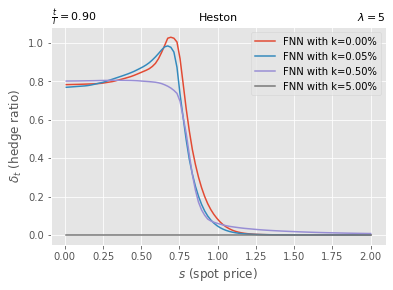

In [ ]:
Lambda=5
I_in_list=1

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_HEST[I_in_list])):
        Delta = np.reshape(F_HEST[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Heston', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

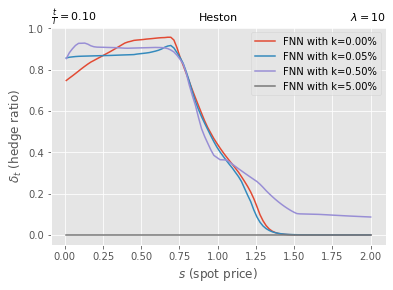

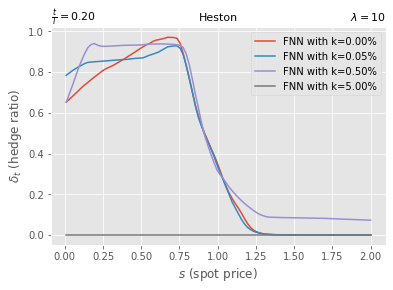

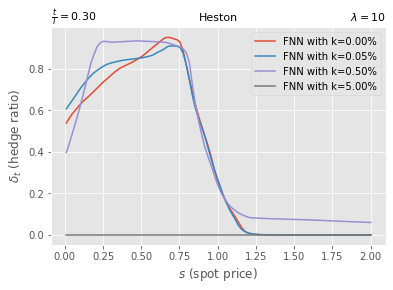

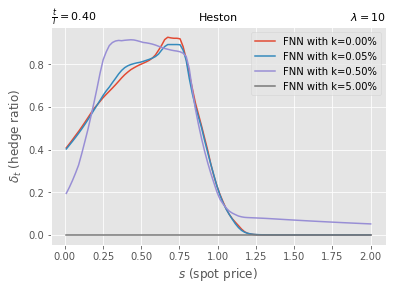

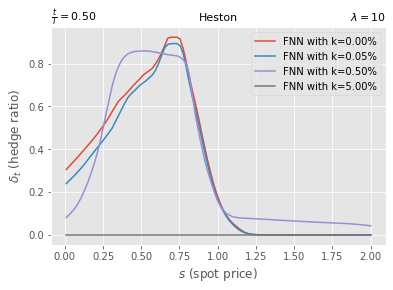

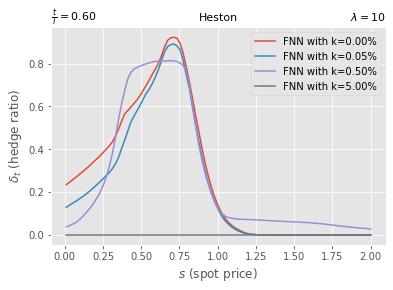

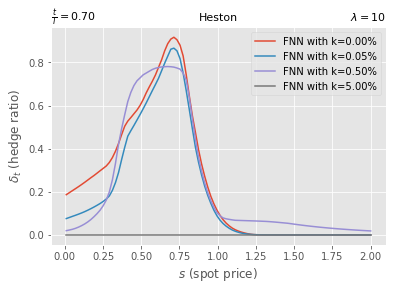

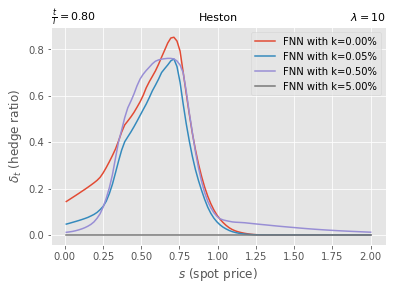

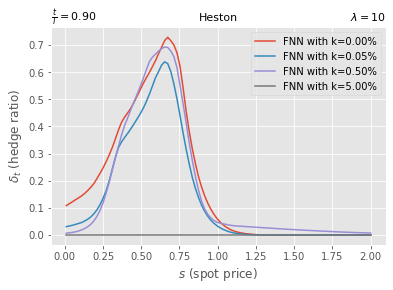

In [ ]:
Lambda=10
I_in_list=2

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_HEST[I_in_list])):
        Delta = np.reshape(F_HEST[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Heston', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

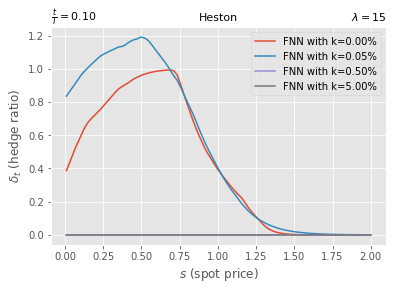

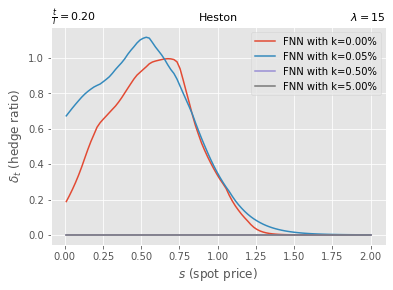

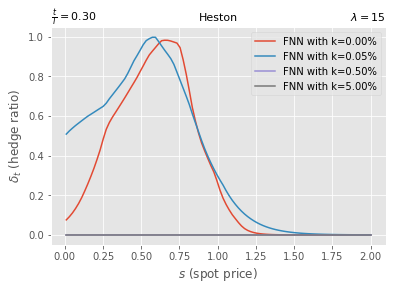

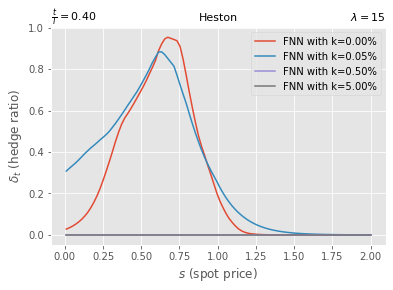

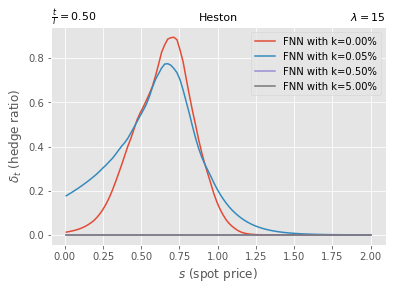

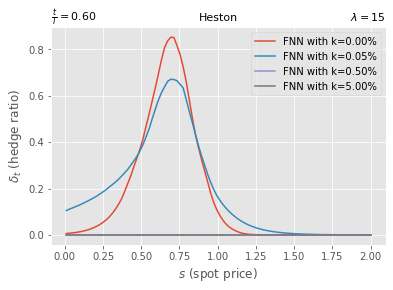

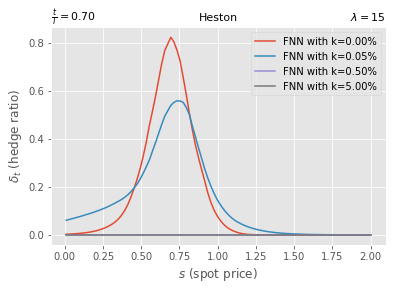

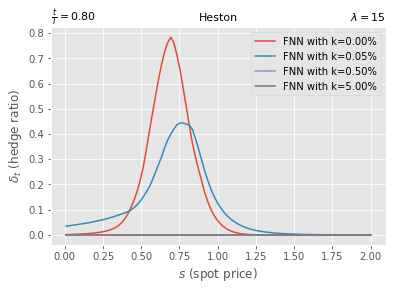

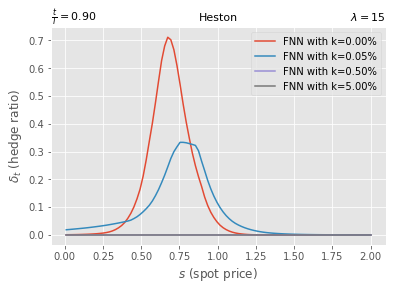

In [ ]:
Lambda=15
I_in_list=3

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_HEST[I_in_list])):
        Delta = np.reshape(F_HEST[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title(r'Heston', loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

## Stock Path simulation

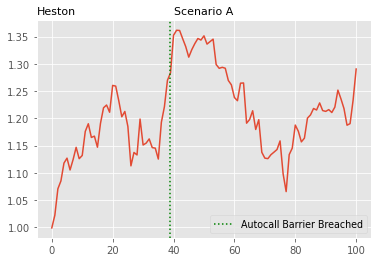

Text(0.5, 1.0, 'Scenario B')

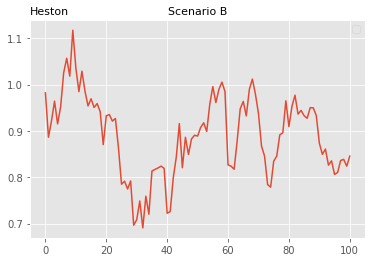

In [ ]:
range_stock_HEST = [3,4]

i  = range_stock_HEST[0]
plt.plot(S_HEST[i])
#plt.axhline(y = B_AC, color = 'green', linestyle='dotted')
plt.axvline(x = 39, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.legend(loc=4,fontsize=9.5)
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.show()

i  = range_stock_HEST[1]
plt.plot(S_HEST[i])
plt.legend()
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)

## Delta Hedge Ratio for varying t

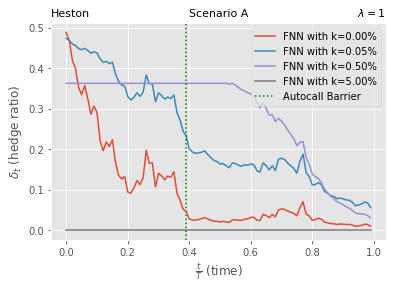

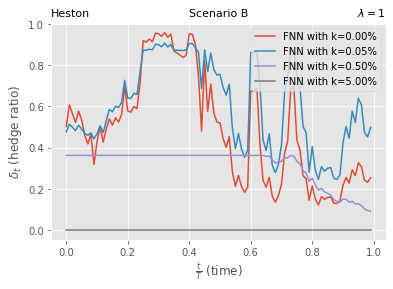

In [ ]:
Lambda=1
I_in_list=0

i  = range_stock_HEST[0]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.39, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_HEST[1]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

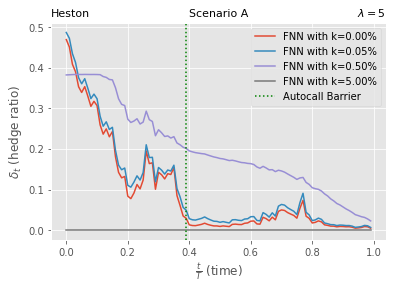

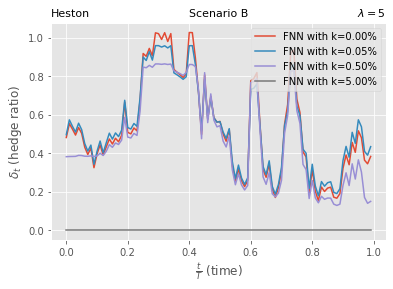

In [ ]:
Lambda=5
I_in_list=1

i  = range_stock_HEST[0]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.39, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_HEST[1]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

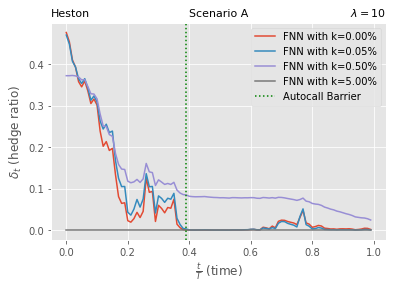

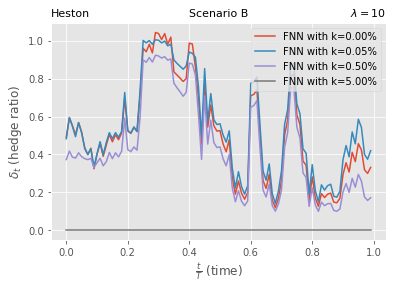

In [ ]:
Lambda=10
I_in_list=2

i  = range_stock_HEST[0]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.39, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_HEST[1]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

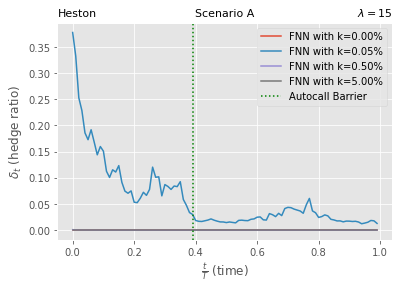

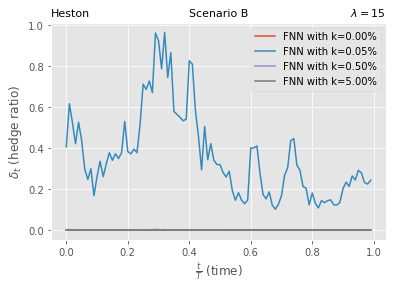

In [ ]:
Lambda=15
I_in_list=3

i  = range_stock_HEST[0]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.axvline(x = 0.39, color = 'green', label = 'Autocall Barrier', linestyle='dotted')
plt.legend()
plt.show()

i  = range_stock_HEST[1]
for j in range(len(F_HEST)):
    Delta_learn = np.reshape(F_HEST[I_in_list][j].predict(X_HEST[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_HEST[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'Heston', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

# Rough Volatility

## Mounting drive and importing libs

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Py scripts

# List files to make sure we're in the expected directory.
# Your output will look different, showing your own Drive files here.
!ls
import sys
sys.path.insert(0,"/content/gdrive/MyDrive/Py scripts/rbergomi.py")
sys.path.insert(0,"/content/gdrive/MyDrive/Py scripts/utils.py")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Py scripts
__pycache__  rbergomi.py  utils.py


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib import pyplot as plt
from rbergomi import rBergomi
from utils import bsinv
vec_bsinv = np.vectorize(bsinv)
import numpy.random as npr
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as kb
plt.style.use('ggplot')

In [ ]:
class Rough_Bergomi:
    
    def __init__(self, S_0, T, a, rho,xi): #N=number of sims
        self.S_0 = S_0
        self.T = T
        self.a = a
        self.rho = rho
        self.xi = xi
        
    def simulate_stock_price(self, steps, N):
        rB = rBergomi(steps, N, self.T, self.a)
        np.random.seed(0)
        dW1 = rB.dW1()
        dW2 = rB.dW2()
        Y = rB.Y(dW1)
        dB = rB.dB(dW1, dW2, rho)
        V = rB.V(Y, xi, eta) 
        S = rB.S(V, dB,S_0)
        return S


## Simulating Stock Path

We set the parameter values as before:

In [ ]:
T = 100
S_0 = 1

npr.seed(12345)
N = 100000
Ti = np.tile(np.linspace(0, 1, T+1)[0:T], (N, 1))
xi = 0.6
r = 0
steps = 100
rho = -0.8
T_mat = 1

In [ ]:
a, eta = -0.43, 1.9
r_bergomi = Rough_Bergomi(S_0, T_mat, a, rho,xi)
S_BERG = r_bergomi.simulate_stock_price(steps, N)
dS_BERG = np.diff(S_BERG, 1, 1)
X_BERG = np.stack([Ti, S_BERG[:,0:T]], axis=-1)

## Training Network

Utility Indifference pricing with Exponential Utility:

\begin{align} \label{eq:exp_utility_function}
-U_\lambda(x):=\frac{1}{\lambda}\exp{(-\lambda x)},\qquad x \in \mathbb{R}
\end{align} 

We used a network $f$ such that
\begin{equation*}
f \in \mathcal{N}_4(2,100,100,100,1; \mathrm{ReLU},\mathrm{ReLU},\mathrm{ReLU},\mathrm{softplus}).
\end{equation*}

In [ ]:
K=1
risk_aversion = (1,5,10,15)
cost_level = (0,0.0005,0.005,0.05)
    
F1_BERG, F5_BERG, F10_BERG, F15_BERG = [], [], [], []
F_BERG = [F1_BERG,F5_BERG,F10_BERG,F15_BERG] #for each lambda
for i in range(len(risk_aversion)):
  for j in range(len(risk_aversion)):
    F_BERG[i].append(keras.Sequential([
    keras.layers.InputLayer(input_shape=(T, 2)),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation=output_activation_layer)]))


In [ ]:
i, j = 0, 0
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 0, 1
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 0, 2
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 0, 3
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 1, 0
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 1, 1
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 1, 2
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 1, 3
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 2, 0
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 2, 1
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 2, 2
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 2, 3
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 3, 0
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 3, 1
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 3, 2
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

i, j = 3, 3
F_BERG[i][j].compile(optimizer='adam', loss=loss_util(risk_aversion[i],cost_level[j],option_type), metrics=[])
F_BERG[i][j].fit(X_BERG, dS_BERG, batch_size=batch_size, epochs=epochs)

Epoch 1/30
1000/1000 [==============================] - 4s 3ms/step - loss: 1.3401
Epoch 2/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3372
Epoch 3/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3363
Epoch 4/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3365
Epoch 5/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3363
Epoch 6/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3364
Epoch 7/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3360
Epoch 8/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3360
Epoch 9/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3360
Epoch 10/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3360
Epoch 11/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3359
Epoch 12/30
1000/1000 [==============================] - 3s 3ms/step - loss: 1.3357
E

## Indifference Pricing

In [ ]:
for i in range(len(F_BERG)):
  for j in range(len(F_BERG[i])):
    loss = F_BERG[i][j].evaluate(X_BERG,dS_BERG)
    result = (1/risk_aversion[i] * np.log(risk_aversion[i]*np.float_(loss)+1))
    k_cost = cost_level[j]*100
    print(r'Risk Aversion=%1.f' % risk_aversion[i], r'Cost level=%1.2f' % k_cost + "%", r'Indiff pricing=%1.22f' % result)

3125/3125 [==============================] - 7s 2ms/step - loss: 1.3348
Risk Aversion=1 Cost level=0.00% Indiff pricing=0.8479312401039791335933
3125/3125 [==============================] - 8s 2ms/step - loss: 1.3390
Risk Aversion=1 Cost level=0.05% Indiff pricing=0.8497428487564643306840
3125/3125 [==============================] - 8s 2ms/step - loss: 1.3605
Risk Aversion=1 Cost level=0.50% Indiff pricing=0.8588763303053178477242
3125/3125 [==============================] - 8s 2ms/step - loss: 1.4018
Risk Aversion=1 Cost level=5.00% Indiff pricing=0.8762387712307777576370
3125/3125 [==============================] - 7s 2ms/step - loss: 16.9426
Risk Aversion=5 Cost level=0.00% Indiff pricing=0.8902013714360971219364
3125/3125 [==============================] - 8s 2ms/step - loss: 17.0025
Risk Aversion=5 Cost level=0.05% Indiff pricing=0.8908986661662370298842
3125/3125 [==============================] - 8s 2ms/step - loss: 17.9751
Risk Aversion=5 Cost level=0.50% Indiff pricing=0.90189

## Delta Hedge Ratio for varying S

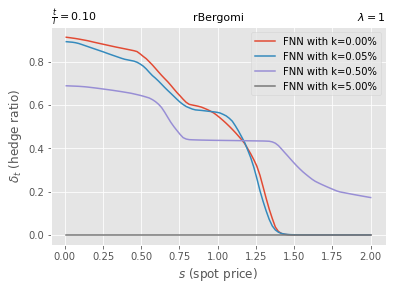

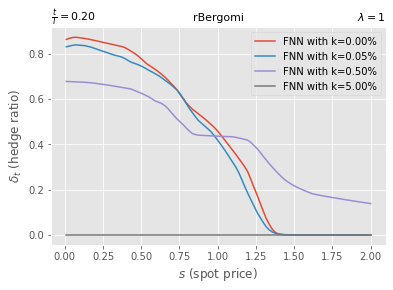

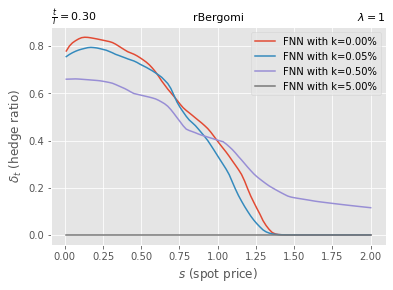

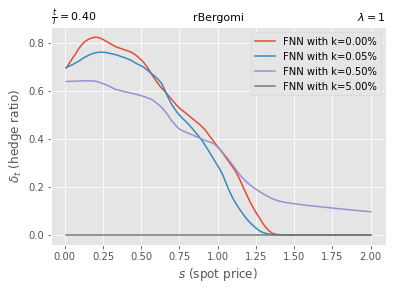

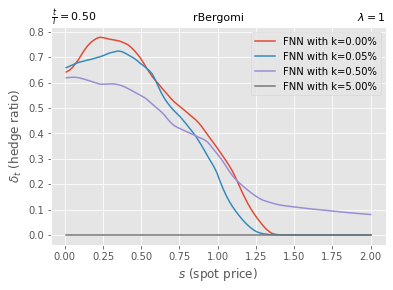

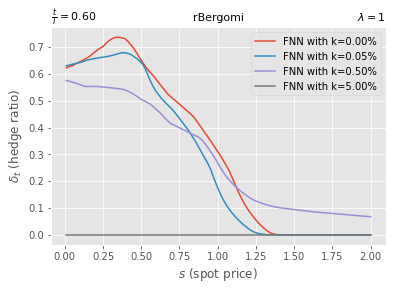

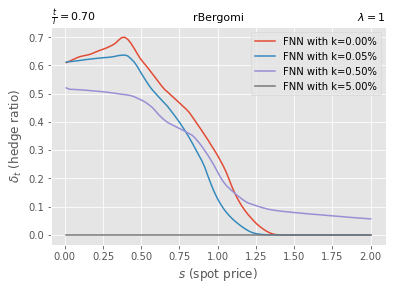

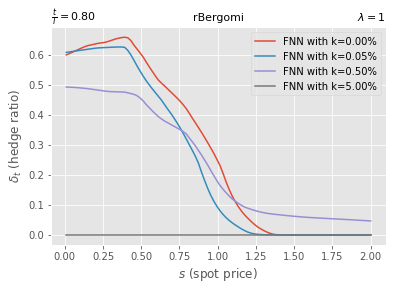

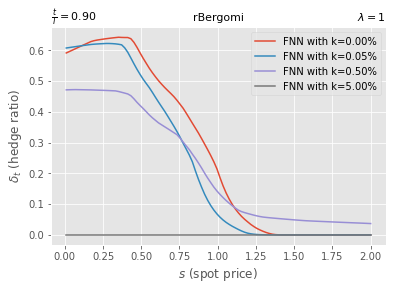

In [ ]:
Lambda=1
I_in_list=0

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BERG[I_in_list])):
        Delta = np.reshape(F_BERG[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title("rBergomi", loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

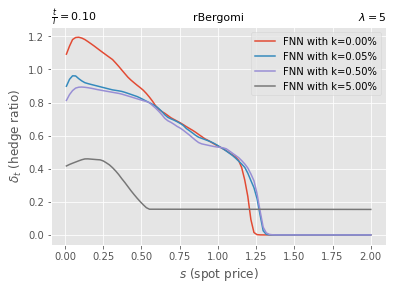

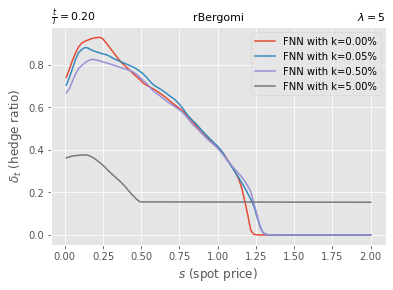

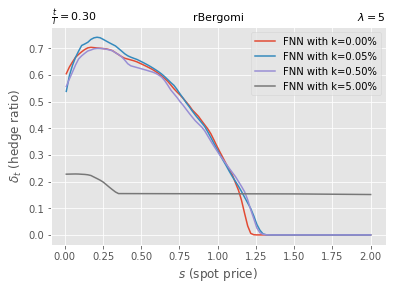

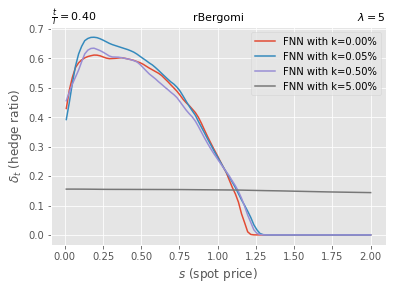

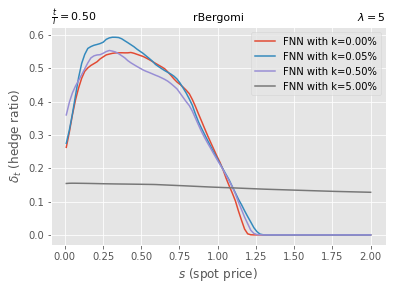

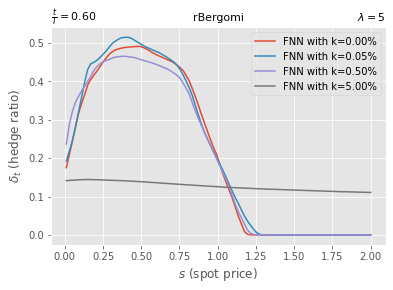

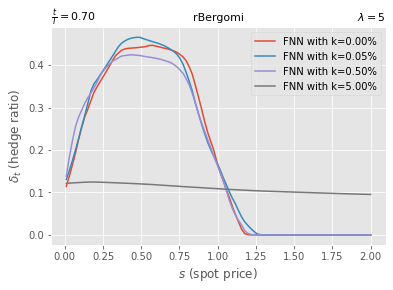

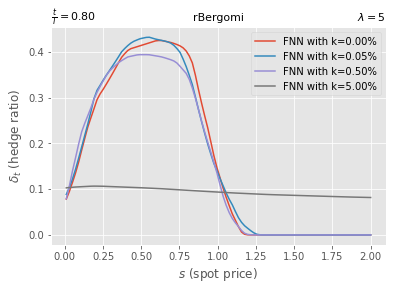

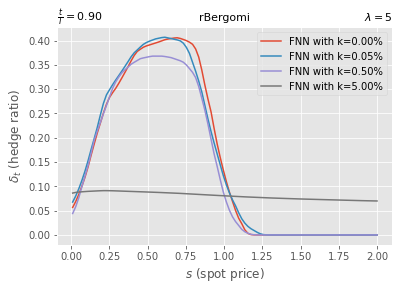

In [ ]:
Lambda=5
I_in_list=1

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BERG[I_in_list])):
        Delta = np.reshape(F_BERG[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title("rBergomi", loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

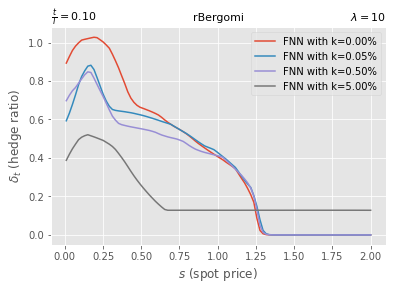

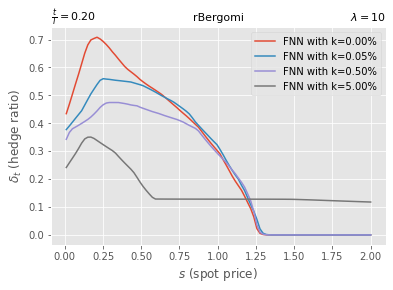

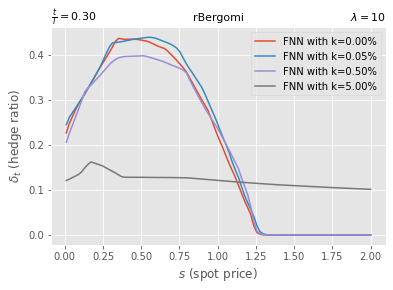

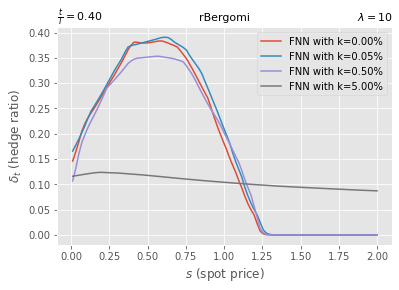

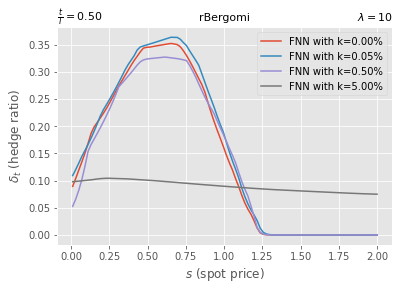

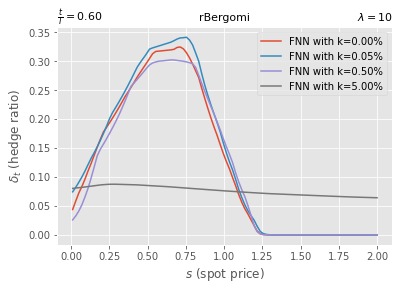

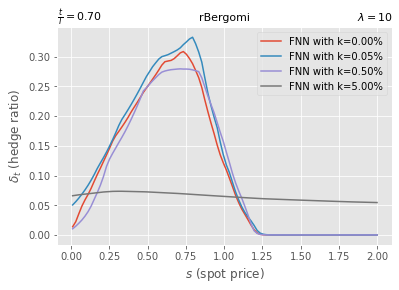

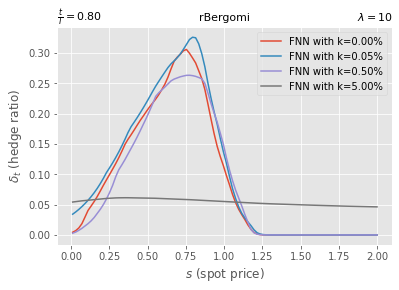

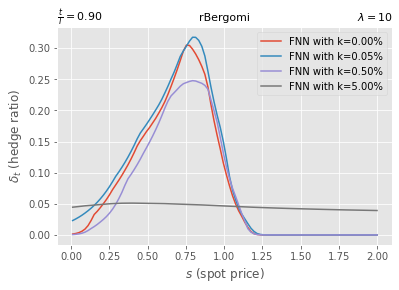

In [ ]:
Lambda=10
I_in_list=2

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BERG[I_in_list])):
        Delta = np.reshape(F_BERG[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title("rBergomi", loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

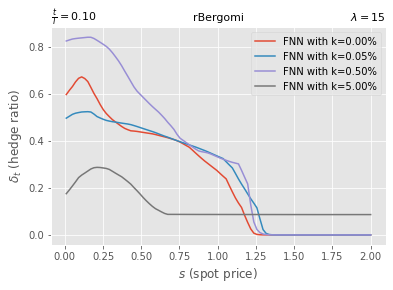

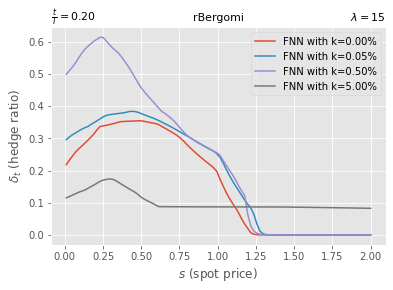

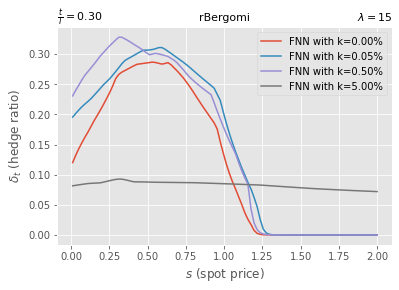

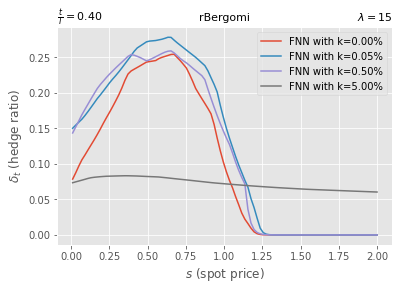

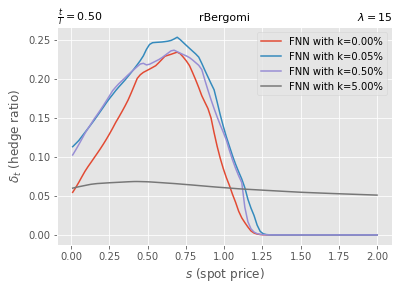

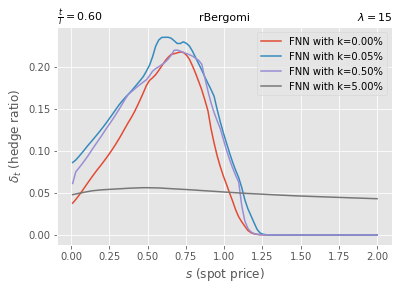

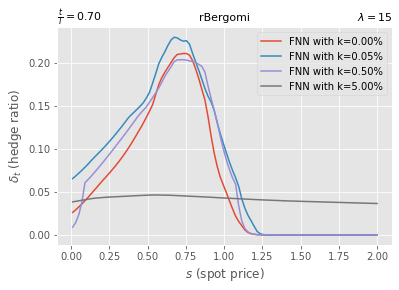

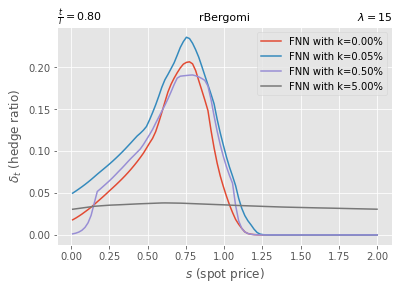

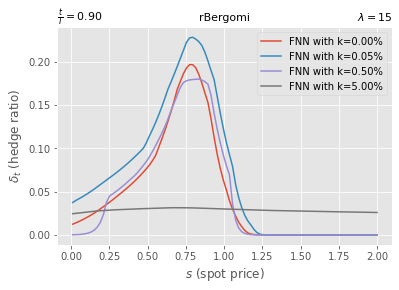

In [ ]:
Lambda=15
I_in_list=3

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    Spr = np.linspace(0.01, 2, num=100)
    dSpr = Spr[1]-Spr[0]
    Xpr = np.stack([np.reshape(np.repeat(t, 100), (1,100)), np.reshape(Spr, (1,100))], axis=-1)
    for j in range(len(F_BERG[I_in_list])):
        Delta = np.reshape(F_BERG[I_in_list][j].predict(Xpr), (100,))
        k = cost_level[j]*100
        plt.plot(Spr, Delta, label=r"FNN with k=%1.2f" % k + "%")
    plt.xlabel(r"$s$ (spot price)")
    plt.ylabel(r"$\delta_t$ (hedge ratio)")
    plt.title(r'$\frac{t}{T}=$%1.2f' % t, loc='left', fontsize=11)
    plt.title("rBergomi", loc='center', fontsize=11)
    plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
    plt.legend()
    plt.show()

## Stock Path simulation

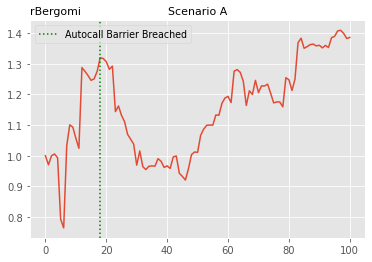

Text(0.0, 1.0, 'rBergomi')

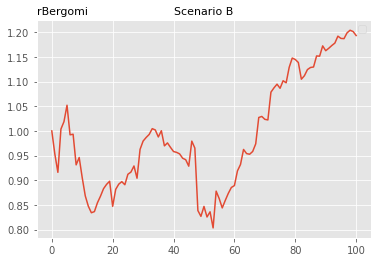

In [ ]:
range_stock_BERG = [25,1]

i  = range_stock_BERG[0]
plt.plot(S_BERG[i])
#plt.axhline(y = B_AC, color = 'green', linestyle='dotted')
plt.axvline(x = 18, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.legend(loc=2,fontsize=9.5)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.title('rBergomi', loc='left', fontsize=11)
plt.show()

i  = range_stock_BERG[1]
plt.plot(S_BERG[i])
plt.legend()
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title('rBergomi', loc='left', fontsize=11)

## Delta Hedge Ratio for varying t

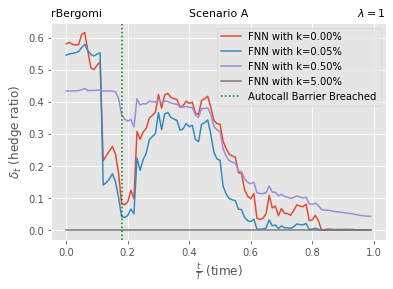

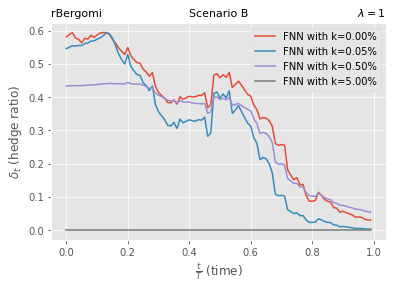

In [ ]:
Lambda=1
I_in_list=0

i  = range_stock_BERG[0]

for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.axvline(x = 0.18, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend(loc=1)
plt.show()

i  = range_stock_BERG[1]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

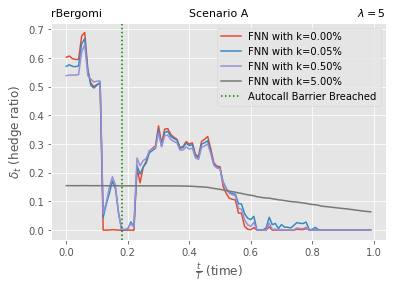

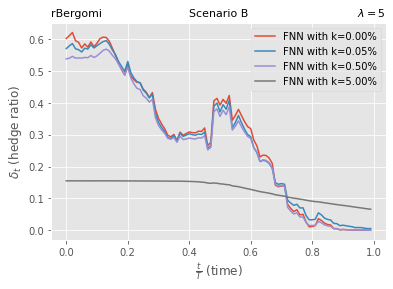

In [ ]:
Lambda=5
I_in_list=1

i  = range_stock_BERG[0]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.axvline(x = 0.18, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

i  = range_stock_BERG[1]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

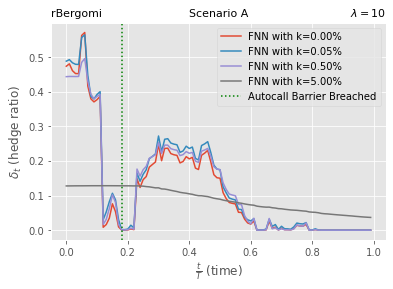

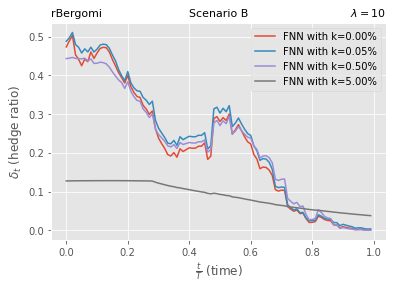

In [ ]:
Lambda=10
I_in_list=2

i  = range_stock_BERG[0]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.axvline(x = 0.18, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

i  = range_stock_BERG[1]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

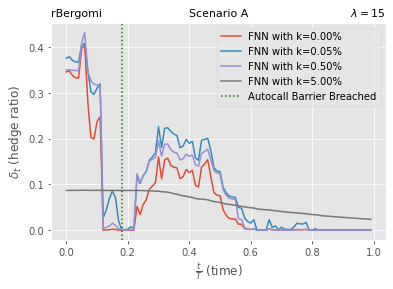

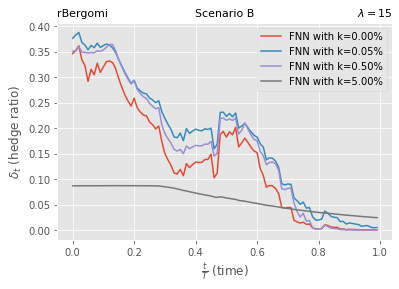

In [ ]:
Lambda=15
I_in_list=3

i  = range_stock_BERG[0]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario A', loc='center', fontsize=11)
plt.axvline(x = 0.18, color = 'green', label = 'Autocall Barrier Breached', linestyle='dotted')
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()

i  = range_stock_BERG[1]
for j in range(len(F_BERG)):
    Delta_learn = np.reshape(F_BERG[I_in_list][j].predict(X_BERG[i:(i+1),:,:]), (T, ))
    k = cost_level[j]*100
    plt.plot(X_BERG[i,:,0], Delta_learn, label=r"FNN with k=%1.2f" % k + "%")
plt.xlabel(r"$\frac{t}{T}$ (time)")
plt.ylabel(r"$\delta_t$ (hedge ratio)")
plt.title(r'rBergomi', loc='left', fontsize=11)
plt.title(r'Scenario B', loc='center', fontsize=11)
plt.title(r'$\lambda=$%1.f' % Lambda, loc='right', fontsize=11)
plt.legend()
plt.show()